<a href="https://colab.research.google.com/github/HariharanSpeed/Deep_Neural_Network/blob/main/Model_Resnet50_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet50 - Model Analysis

Edge SoC Optimization & Quantization Analysis

Model: ResNet50
Dataset: Tiny-ImageNet (10-class subset + 200-class validation)

To evaluate and compare:

FP32 vs INT8 performance
Base pretrained vs Transfer learning
PTQ vs QAT quantization
Accuracy vs Latency trade-offs
Suitability for Edge SoC deployment

Models Evaluated (Total: 5)

Base Models (1000-class ImageNet)

1 Base FP32 ResNet50

Pretrained on ImageNet
1000 output classes
Evaluated using Tiny-ImageNet images
Labels mapped to original ImageNet index

2 Base INT8 ResNet50 (PTQ)

Static quantization
Calibration performed
1000 output classes
Compared against FP32 baseline

Transfer Learning Models (10-class Tiny subset)

3 Transfer FP32 ResNet50 (10-class)

Final layer replaced
Fine-tuned on selected 10 Tiny classes

4 Transfer INT8 (PTQ)

Post-Training Quantization
Converted from trained FP32 transfer model

5 Transfer INT8 (QAT)

Quantization Aware Training
Fake quant during training
Converted to real INT8

Dataset Strategy

Tiny-ImageNet Structure

200 classes
500 training images per class
50 validation images per class

## Data Preparation

### Installing Dependencies

In [ ]:
! pip install numpy pandas matplotlib seaborn scikit-learn requests torch torchvision transformers opencv-python onnxscript kagglehub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 78.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.3/159.3 kB 11.4 MB/s eta 0:00:00


### Importing Modules

In [ ]:
# Importing Libaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, balanced_accuracy_score
from sklearn.preprocessing import label_binarize

import time
import json
import os
import shutil
from pathlib import Path
import zipfile
import urllib.request
import random
import requests
from collections import Counter
import warnings

# Deep Learning Libaries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from torch.quantization import fuse_modules
import torch.ao.quantization as quant
import torch.quantization
import torchvision.models.quantization as quant_models

from onnxscript import ir

# For image processing
from PIL import Image
import cv2

print("All modules import successfully")

All modules import successfully


### Downloading the dataset

In [ ]:
!curl -L -o imagenet1kvalid.zip\
  https://www.kaggle.com/api/v1/datasets/download/sautkin/imagenet1kvalid
!unzip imagenet1kvalid.zip
!rm imagenet1kvalid.zip

In [ ]:
# !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
# !unzip tiny-imagenet-200.zip
# !wget -q https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json

Streaming output truncated to the last 5000 lines.
  inflating: tiny-imagenet-200/val/images/val_3979.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3963.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7199.JPEG  
  inflating: tiny-imagenet-200/val/images/val_2752.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9687.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9407.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3603.JPEG  
  inflating: tiny-imagenet-200/val/images/val_3412.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6982.JPEG  
  inflating: tiny-imagenet-200/val/images/val_8496.JPEG  
  inflating: tiny-imagenet-200/val/images/val_7332.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9241.JPEG  
  inflating: tiny-imagenet-200/val/images/val_4196.JPEG  
  inflating: tiny-imagenet-200/val/images/val_5980.JPEG  
  inflating: tiny-imagenet-200/val/images/val_6697.JPEG  
  inflating: tiny-imagenet-200/val/images/val_9969.JPEG  
  inflating: tiny-ima

### Creating Imagnet V1 1000 classs mapping for base model

In [ ]:
import json

with open("imagenet_class_index.json") as f:
    class_idx = json.load(f)

# Build WNID → ImageNet index mapping
class_idx = {
    v[0]: int(k) for k, v in class_idx.items()
}

print("Total ImageNet classes:", len(class_idx))  # should be 1000

Total ImageNet classes: 1000


### Creating the limited class filter for analysis

In [ ]:
selected_classes = ["n01443537", "n01629819", "n01641577", "n01644900", "n01698640", "n01742172", "n01768244", "n01770393", "n01774384", "n01774750"]

#### checking for missing folder in the classs map

In [ ]:
missing = [
    wnid for wnid in selected_classes
    if wnid not in class_idx
]

print("Missing WNIDs:", missing)

Missing WNIDs: []


### Creating selected class mapping for the base model for 1000 classes

In [ ]:
selected_wnid_to_class_idx = {
    wnid: class_idx[wnid]
    for wnid in selected_classes
    if wnid in class_idx
}

print("Mapped selected classes:", len(selected_wnid_to_class_idx))
print(selected_wnid_to_class_idx)

Mapped selected classes: 10
{'n01443537': 1, 'n01629819': 25, 'n01641577': 30, 'n01644900': 32, 'n01698640': 50, 'n01742172': 61, 'n01768244': 69, 'n01770393': 71, 'n01774384': 75, 'n01774750': 76}


### Creating folder name to human understable class naming map

In [ ]:
words_file = "/content/tiny-imagenet-200/words.txt"

wnid_to_name = {}

with open(words_file, 'r') as f:
    for line in f:
        wnid, name = line.strip().split("\t")
        wnid_to_name[wnid] = name

for cls in selected_classes:
    print(cls, "→", wnid_to_name[cls])

n01443537 → goldfish, Carassius auratus
n01629819 → European fire salamander, Salamandra salamandra
n01641577 → bullfrog, Rana catesbeiana
n01644900 → tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui
n01698640 → American alligator, Alligator mississipiensis
n01742172 → boa constrictor, Constrictor constrictor
n01768244 → trilobite
n01770393 → scorpion
n01774384 → black widow, Latrodectus mactans
n01774750 → tarantula


### Moving the image from validation folder to their respective class folder for easy loading

In [ ]:


val_root = "/content/tiny-imagenet-200/val"
val_images_dir = os.path.join(val_root, "images")

val_annotations = pd.read_csv(
    os.path.join(val_root, "val_annotations.txt"),
    sep="\t",
    header=None,
    names=["image", "wnid", "x1", "y1", "x2", "y2"]
)

moved = 0

for _, row in val_annotations.iterrows():
    img = row["image"]
    wnid = row["wnid"]

    # 🔥 Only process selected classes
    if wnid not in selected_classes:
        continue

    src = os.path.join(val_images_dir, img)
    dst_folder = os.path.join(val_images_dir, wnid)
    dst = os.path.join(dst_folder, img)

    if not os.path.exists(src):
        continue  # already moved

    os.makedirs(dst_folder, exist_ok=True)
    shutil.move(src, dst)
    moved += 1

print(f"✅ Validation folder organized for selected classes. Moved {moved} images.")
print(len(os.listdir(val_images_dir)))


✅ Validation folder organized for selected classes. Moved 500 images.
9510


### Creating Dataset class for loading the dataset

In [ ]:
class CustomClassImageNet(Dataset):
    def __init__(self, root_dir, class_idx, transform=None):
        self.samples = []
        self.transform = transform
        self.classes = list(class_idx.keys())
        self.class_to_idx = class_idx

        for wnid, idx in class_idx.items():
            train_dir = os.path.join(root_dir, wnid, "images")

            val_dir = os.path.join(root_dir, wnid)

            if os.path.isdir(train_dir):
                cls_dir = train_dir
            elif os.path.isdir(val_dir):
                cls_dir = val_dir
            else:
                continue

            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith((".jpeg", ".jpg", ".png")):
                    img_path = os.path.join(cls_dir, img_name)
                    self.samples.append((img_path, idx))

        print("Total samples:", len(self.samples))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label




### creating transform for train and test set for base and transfer learning model

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

test_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

### Creating train Dataloader for transfer learning

In [ ]:
train_root = "/content/tiny-imagenet-200/train"

train_dataset = CustomClassImageNet(
    root_dir="/content/tiny-imagenet-200/train",
    class_idx={cls: i for i, cls in enumerate(selected_classes)},
    transform=train_transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

print("Total training samples:", len(train_dataset))
print("Class mapping:", train_dataset.class_to_idx)


Total samples: 5000
Total training samples: 5000
Class mapping: {'n01443537': 0, 'n01629819': 1, 'n01641577': 2, 'n01644900': 3, 'n01698640': 4, 'n01742172': 5, 'n01768244': 6, 'n01770393': 7, 'n01774384': 8, 'n01774750': 9}


###  Creating test Dataloader for base model as well as transfer learning model

In [ ]:
test_root = "/content/tiny-imagenet-200/val/images"
base_test_dataset = CustomClassImageNet(
    root_dir=test_root,
    class_idx=selected_wnid_to_class_idx,
    transform=test_transform
)

test_dataset = CustomClassImageNet(
    root_dir=test_root,
    class_idx={cls: i for i, cls in enumerate(selected_classes)},
    transform=test_transform
)

base_test_loader = DataLoader(
    base_test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0
)

print("Total test samples:", len(base_test_dataset))
print("Total test samples:", len(test_dataset))

Total samples: 500
Total samples: 500
Total test samples: 500
Total test samples: 500


### Checking the Class image distribution in the validation folder

In [ ]:
from collections import Counter

class_counts = {}

for cls in os.listdir(val_images_dir):
    cls_path = os.path.join(val_images_dir, cls)

    if os.path.isdir(cls_path):
        num_images = len([
            f for f in os.listdir(cls_path)
            if f.lower().endswith((".jpeg", ".jpg", ".png"))
        ])
        class_counts[cls] = num_images

print("Total classes:", len(class_counts))
print("Total validation images:", sum(class_counts.values()))
unique_counts = set(class_counts.values())
print("Unique image counts per class:", unique_counts)

Total classes: 10
Total validation images: 500
Unique image counts per class: {50}


In [ ]:
import pandas as pd

df = pd.DataFrame.from_dict(class_counts, orient="index", columns=["num_images"])
df = df.sort_values("num_images", ascending=False)

df.head(10)

,num_images
n01742172,50
n01641577,50
n01774384,50
n01770393,50
n01644900,50
n01774750,50
n01629819,50
n01698640,50
n01443537,50
n01768244,50


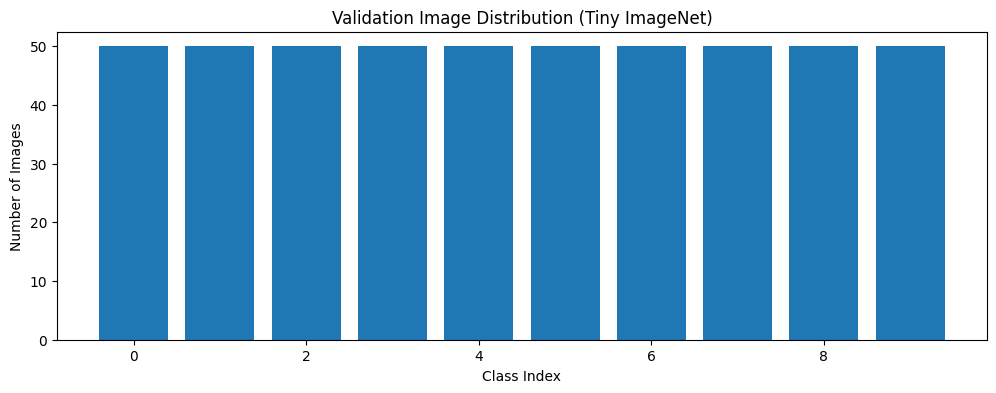

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.bar(range(len(class_counts)), list(class_counts.values()))
plt.title("Validation Image Distribution (Tiny ImageNet)")
plt.xlabel("Class Index")
plt.ylabel("Number of Images")
plt.show()

In [ ]:
selected_distribution = {
    cls: class_counts.get(cls, 0)
    for cls in selected_classes
}

print(selected_distribution)

{'n01443537': 50, 'n01629819': 50, 'n01641577': 50, 'n01644900': 50, 'n01698640': 50, 'n01742172': 50, 'n01768244': 50, 'n01770393': 50, 'n01774384': 50, 'n01774750': 50}


## Analysing the model

In [ ]:
model_metrics = []

### Plot functions

In [ ]:
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(6,5))
    sns.heatmap(cm,
                annot=True,
                fmt="d",
                cmap="Blues",
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")

    plt.tight_layout()
    # saving the confustion matrix image
    plt.savefig(f"confusion_matrix_{model_name}.png", dpi=300)
    plt.show()



def plot_roc_curve(fpr, tpr, roc_auc, num_classes, model_name):
    plt.figure(figsize=(6,6))
    for i in range(num_classes):
        plt.plot(
            fpr[i],
            tpr[i],
            label=f"Class {i} (AUC={roc_auc[i]:.2f})"
        )

    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(fontsize=7)
    plt.tight_layout()
    plt.savefig(f"roc_curve_{model_name}.png", dpi=300)
    plt.show()

### Metric Functions

In [ ]:
def metrics_calculation(all_labels, all_preds, all_probs, num_classes, total_samples, total_time, model_name):
    # Accuracy Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(
        all_labels, all_preds,
        average='weighted',
        zero_division=0
    )
    recall = recall_score(
        all_labels, all_preds,
        average='weighted',
        zero_division=0
    )
    f1 = f1_score(
        all_labels, all_preds,
        average='weighted',
        zero_division=0
    )
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    # Top-5 Accuracy
    top5_preds = np.argsort(all_probs, axis=1)[:, -5:]
    top5_correct = sum(
        all_labels[i] in top5_preds[i]
        for i in range(len(all_labels))
    )
    top5_accuracy = top5_correct / len(all_labels)

    # ROC + AUC (multiclass)
    y_true_bin = label_binarize(
        all_labels,
        classes=list(range(num_classes))
    )

    roc_auc = {}
    fpr_dict = {}
    tpr_dict = {}
    macro_auc = None

    if num_classes <= 50:   # 🔥 Skip ROC for 1000-class case

        y_true_bin = label_binarize(
            all_labels,
            classes=list(range(num_classes))
        )

        label_counts = Counter(all_labels)

        for i in range(num_classes):
            if label_counts[i] > 0:

                fpr_i, tpr_i, _ = roc_curve(
                    y_true_bin[:, i],
                    all_probs[:, i]
                )

                roc_auc[i] = auc(fpr_i, tpr_i)
                fpr_dict[i] = fpr_i
                tpr_dict[i] = tpr_i

        if len(roc_auc) > 0:
            macro_auc = float(np.mean(list(roc_auc.values())))
    # Latency + FPS
    avg_latency = total_time / total_samples   # seconds per image
    latency_ms = avg_latency * 1000
    fps = 1 / avg_latency

    # plot_confusion_matrix(cm, model_name)
    # plot_roc_curve(fpr, tpr, roc_auc, num_classes, model_name)

    size_mb = os.path.getsize(f"resnet50_{model_name}.pth") / (1024 * 1024)

    # Print Summary
    print("Evaluation Metrics")
    print(f"Accuracy          : {accuracy:.4f}")
    print(f"Balanced Accuracy : {balanced_acc:.4f}")
    print(f"Precision         : {precision:.4f}")
    print(f"Recall            : {recall:.4f}")
    print(f"F1 Score          : {f1:.4f}")
    print(f"Top-5 Accuracy    : {top5_accuracy:.4f}")
    if macro_auc is not None:
        print(f"Macro AUC         : {macro_auc:.4f}")
    print(f"Latency (ms/img)  : {latency_ms:.4f}")
    print(f"FPS               : {fps:.2f}")
    print(f"Model Size (MB)   : {size_mb}")

    metrics = {
        "accuracy": float(accuracy),
        "balanced_accuracy": float(balanced_acc),
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1),
        "top5_accuracy": float(top5_accuracy),
        "macro_auc": macro_auc,
        "latency_ms": float(latency_ms),
        "fps": float(fps),
        "model_size_mb": float(size_mb)
    }

    # saving the model metrics
    with open(f"resnet50_{model_name}_metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)

### Function to Train the model

In [ ]:
def train_model(model, data_loader, epochs, optimizer, criterion, device):
    training_loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        training_loss_history.append(running_loss / len(data_loader))

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(data_loader):.4f}")

    return training_loss_history

### function to Test the model

In [ ]:
def test_model_metric(model, data_loader, device, num_classes, model_name):

    if "quantized" in str(type(model)).lower():
        device = torch.device("cpu")
        model = model.to(device)

    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []

    total_time = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, _ in data_loader:
            images = images.to(device)
            model(images)
            break

    with torch.no_grad():
        for images, labels in data_loader:

            images = images.to(device)
            labels = labels.to(device)

            start = time.perf_counter()
            outputs = model(images)
            end = time.perf_counter()

            batch_time = end - start

            total_time += batch_time
            total_samples += images.size(0)

            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(
        all_labels, all_preds,
        average='weighted',
        zero_division=0
    )
    recall = recall_score(
        all_labels, all_preds,
        average='weighted',
        zero_division=0
    )
    f1 = f1_score(
        all_labels, all_preds,
        average='weighted',
        zero_division=0
    )
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    top5_preds = np.argsort(all_probs, axis=1)[:, -5:]
    top5_correct = sum(
        all_labels[i] in top5_preds[i]
        for i in range(len(all_labels))
    )
    top5_accuracy = top5_correct / len(all_labels)

    roc_auc = {}
    macro_auc = None

    if num_classes <= 50:
        y_true_bin = label_binarize(
            all_labels,
            classes=list(range(num_classes))
        )

        label_counts = Counter(all_labels)

        for i in range(num_classes):
            if label_counts[i] > 0:
                fpr_i, tpr_i, _ = roc_curve(
                    y_true_bin[:, i],
                    all_probs[:, i]
                )
                roc_auc[i] = auc(fpr_i, tpr_i)

        if len(roc_auc) > 0:
            macro_auc = float(np.mean(list(roc_auc.values())))


    avg_latency = total_time / total_samples
    latency_ms = avg_latency * 1000
    fps = 1 / avg_latency

     # saving the model
    print(f"Metrics saved to resnet50_{model_name}.pth")
    torch.save(model.state_dict(), f"resnet50_{model_name}.pth")
    size_mb = os.path.getsize(f"resnet50_{model_name}.pth") / (1024 * 1024)

    print("\n=== Evaluation Metrics ===")
    print(f"Accuracy          : {accuracy:.4f}")
    print(f"Balanced Accuracy : {balanced_acc:.4f}")
    print(f"Precision         : {precision:.4f}")
    print(f"Recall            : {recall:.4f}")
    print(f"F1 Score          : {f1:.4f}")
    print(f"Top-5 Accuracy    : {top5_accuracy:.4f}")
    if macro_auc is not None:
        print(f"Macro AUC         : {macro_auc:.4f}")
    print(f"Latency (ms/img)  : {latency_ms:.4f}")
    print(f"FPS               : {fps:.2f}")
    print(f"Model Size (MB)   : {size_mb:.2f}")

    metrics = {
        "model_name": model_name,
        "accuracy": float(accuracy),
        "balanced_accuracy": float(balanced_acc),
        "precision": float(precision),
        "recall": float(recall),
        "f1_score": float(f1),
        "top5_accuracy": float(top5_accuracy),
        "macro_auc": macro_auc,
        "latency_ms": float(latency_ms),
        "fps": float(fps),
        "model_size_mb": float(size_mb)
    }

    # Save metrics
    with open(f"{model_name}_metrics.json", "w") as f:
        json.dump(metrics, f, indent=4)

    return metrics, cm, roc_auc

Checking for device

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Base FP32 Model

### Loading the model

In [ ]:
base_num_classes = 1000
base_fp32_model = models.resnet50(pretrained=True)
base_fp32_model = base_fp32_model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 73.0MB/s]


### Testing and saving the model and the metrics

In [ ]:

model_metrics.append(test_model_metric(base_fp32_model, base_test_loader, device, base_num_classes, model_name="base_fp32"))



=== Evaluation Metrics ===
Accuracy          : 0.2880
Balanced Accuracy : 0.2880
Precision         : 0.9219
Recall            : 0.2880
F1 Score          : 0.3995
Top-5 Accuracy    : 0.5300
Latency (ms/img)  : 78.8820
FPS               : 12.68
Model Size (MB)   : 97.79


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## Base PAT Qunatization INT8 Model

### Loading the qunatized int8 base model

In [ ]:
from torchvision.models.quantization import ResNet50_QuantizedWeights
torch.backends.quantized.engine = 'fbgemm'

device = torch.device("cpu")

base_int8_model = quant_models.resnet50(
    weights=ResNet50_QuantizedWeights.IMAGENET1K_FBGEMM_V1,
    quantize=True
)

base_int8_model = base_int8_model.to(device)

Downloading: "https://download.pytorch.org/models/quantized/resnet50_fbgemm_bf931d71.pth" to /root/.cache/torch/hub/checkpoints/resnet50_fbgemm_bf931d71.pth


100%|██████████| 24.8M/24.8M [00:00<00:00, 62.3MB/s]
/usr/local/lib/python3.12/dist-packages/torch/_utils.py:450: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  scales = torch.tensor(scales, dtype=torch.double, device=storage.device)


### Testing the model and getting the metrics

In [ ]:

model_metrics.append(test_model_metric(base_int8_model, test_loader, device, base_num_classes, model_name="base_int8"))


=== Evaluation Metrics ===
Accuracy          : 0.0000
Balanced Accuracy : 0.0000
Precision         : 0.0000
Recall            : 0.0000
F1 Score          : 0.0000
Top-5 Accuracy    : 0.0160
Latency (ms/img)  : 38.7528
FPS               : 25.80
Model Size (MB)   : 24.96


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


## Transfer learning FP32 model

### Loading the base model for Transfer Learning

In [ ]:
num_classes = len(selected_classes)

tl_fp32_model = models.resnet50(pretrained=True)

for param in tl_fp32_model.parameters():
    param.requires_grad = False

tl_fp32_model.fc = nn.Linear(tl_fp32_model.fc.in_features, num_classes)

for param in tl_fp32_model.fc.parameters():
    param.requires_grad = True

tl_fp32_model = tl_fp32_model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training the model for fine tuning

In [ ]:
optimizer_used = "Adam"
learning_rate = 5e-4

tl_fp32_criterion = nn.CrossEntropyLoss()
tl_fp32_optimizer = optim.Adam(tl_fp32_model.fc.parameters(), lr=learning_rate)

# training the model
tl_fp32_loss = train_model(model=tl_fp32_model,
                            data_loader=train_loader,
                            epochs=10,
                            optimizer=tl_fp32_optimizer,
                            criterion=tl_fp32_criterion,
                            device=device)

Epoch [1/10] Loss: 1.3638
Epoch [2/10] Loss: 0.9409
Epoch [3/10] Loss: 0.8799
Epoch [4/10] Loss: 0.8331
Epoch [5/10] Loss: 0.7941
Epoch [6/10] Loss: 0.7770
Epoch [7/10] Loss: 0.7701
Epoch [8/10] Loss: 0.7746
Epoch [9/10] Loss: 0.7551
Epoch [10/10] Loss: 0.7512


### Testing and Saving the model and metrics

In [ ]:

model_metrics.append(test_model_metric(tl_fp32_model, test_loader, device, num_classes, model_name="tl_fp32"))

Metrics saved to resnet50_tl_fp32.pth

=== Evaluation Metrics ===
Accuracy          : 0.7320
Balanced Accuracy : 0.7320
Precision         : 0.7526
Recall            : 0.7320
F1 Score          : 0.7347
Top-5 Accuracy    : 0.9660
Macro AUC         : 0.9587
Latency (ms/img)  : 84.5508
FPS               : 11.83
Model Size (MB)   : 90.06


## Transfer Learning PAT Quantization INT8 Model

### Loading the Tranfer Learning fp32 model for PAT Quantization conversion

In [ ]:

import torchvision.models.quantization as quant_models

tl_qat_fp32_model = quant_models.resnet50(pretrained=False)
tl_qat_fp32_model.fc = torch.nn.Linear(tl_qat_fp32_model.fc.in_features, num_classes)
tl_qat_fp32_model.load_state_dict(
    torch.load("resnet50_tl_fp32.pth", map_location="cpu")
)
tl_qat_fp32_model.eval()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


QuantizableResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QuantizableBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [ ]:
# Fuse Conv + BN + ReLU blocks
tl_qat_fp32_model.fuse_model()

In [ ]:
torch.backends.quantized.engine = 'fbgemm'   # Important for x86 CPU

# Set model to evaluation mode
tl_qat_fp32_model.eval()

# Assign quantization config
tl_qat_fp32_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')

# Prepare model for calibration
torch.quantization.prepare(tl_qat_fp32_model, inplace=True)

# ---- Calibration Step ----
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        tl_qat_fp32_model(images)

# Convert to INT8
tl_ptq_int8_model = torch.quantization.convert(tl_qat_fp32_model, inplace=False)

print("PTQ model created (INT8)")

/tmp/ipython-input-4130557096.py:10: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.quantization.prepare(tl_qat_fp32_model, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future rel

PTQ model created (INT8)


### Testing and Saving the model and metrics

In [ ]:

model_metrics.append(test_model_metric(tl_ptq_int8_model, test_loader, device, num_classes, model_name="tl_ptq_int8"))


Metrics saved to resnet50_tl_ptq_int8.pth

=== Evaluation Metrics ===
Accuracy          : 0.7200
Balanced Accuracy : 0.7200
Precision         : 0.7480
Recall            : 0.7200
F1 Score          : 0.7222
Top-5 Accuracy    : 0.9700
Macro AUC         : 0.9592
Latency (ms/img)  : 33.8812
FPS               : 29.51
Model Size (MB)   : 23.01


## Transfer Learnig QAT Quantization INT8 Model

### Loading Transfer Learning model for QAT Quantization

In [ ]:

device = torch.device("cpu")  # QAT training can be CPU or GPU

# Create quantization-ready ResNet50
tl_qat_fp32_model = quant_models.resnet50(pretrained=False)

# Replace classifier
tl_qat_fp32_model.fc = torch.nn.Linear(tl_qat_fp32_model.fc.in_features, num_classes)

# Load your trained FP32 TL weights
tl_qat_fp32_model.load_state_dict(
    torch.load("resnet50_tl_fp32.pth", map_location=device)
)

tl_qat_fp32_model.train()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


QuantizableResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): QuantizableBottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1)

In [ ]:
tl_qat_fp32_model.fuse_model()


In [ ]:
torch.backends.quantized.engine = 'fbgemm'

tl_qat_fp32_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')

# Prepare for QAT (inserts fake quant modules)
torch.quantization.prepare_qat(tl_qat_fp32_model, inplace=True)

print("Model prepared for QAT training")

/tmp/ipython-input-3040053435.py:6: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  torch.quantization.prepare_qat(tl_qat_fp32_model, inplace=True)
/usr/local/lib/python3.12/dist-packages/torch/ao/quantization/observer.py:246: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future 

Model prepared for QAT training


### Dataloader for QAT

In [ ]:
qat_train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    persistent_workers=False
)

### Training the model for Quantization

In [ ]:
qat_learning_rate = 5e-4

tl_qat_int8_criterion = nn.CrossEntropyLoss()
tl_qat_int8_optimizer = optim.Adam(tl_qat_fp32_model.parameters(), lr=qat_learning_rate)

# training the model
tl_qat_int8_loss = train_model(model=tl_qat_fp32_model,
                            data_loader=qat_train_loader,
                            epochs=5,
                            optimizer=tl_qat_int8_optimizer,
                            criterion=tl_qat_int8_criterion,
                            device=device)

Epoch [1/5] Loss: 1.2322
Epoch [2/5] Loss: 0.7460
Epoch [3/5] Loss: 0.5889
Epoch [4/5] Loss: 0.5537
Epoch [5/5] Loss: 0.4734


### Converting the model to INT8 after Training

In [ ]:
tl_qat_fp32_model.eval()

tl_qat_int8_model = torch.quantization.convert(tl_qat_fp32_model, inplace=False)

print("QAT INT8 model created successfully")

/tmp/ipython-input-4115288035.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  tl_qat_int8_model = torch.quantization.convert(tl_qat_fp32_model, inplace=False)


QAT INT8 model created successfully


# Testing and Saving for model and metrics

In [ ]:

model_metrics.append(test_model_metric(tl_qat_int8_model, test_loader, device, num_classes, model="tl_qat_int8"))


TypeError: test_model_metric() got multiple values for argument 'model'

## Comparsion Analysis

# Latency and Size measurement

In [ ]:

comparison_table = pd.DataFrame(model_metrics)

comparison_table

### Accuracy Comparison

In [ ]:
comparison_table.plot(
    x="Model",
    y="Accuracy",
    kind="bar",
    figsize=(8,5),
    title="Model Accuracy Comparison"
)
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()

# Save before showing
plt.savefig("accuracy_comparison.png", dpi=300)
plt.show()

### Latency Comparison

In [ ]:
comparison_table.plot(
    x="Model",
    y="Latency (ms)",
    kind="bar",
    figsize=(8,5),
    title="Latency Comparison"
)
plt.ylabel("Latency ")
plt.xticks(rotation=45)
plt.tight_layout()

# Save before showing
plt.savefig("latency_comparison.png", dpi=300)
plt.show()